In [1]:
""" Copyright chriskeraly
    Copyright (c) 2019 Lumerical Inc. """
"""
General setup section to get what we need to test things
"""
######## IMPORTS ########
# General purpose imports
import os
import numpy as np
import scipy as sp
import scipy.interpolate
import sys

# add lumapi to path
sys.path.append(r"C:\Program Files\Lumerical\v202\api\python")

# Optimization specific imports
from lumopt.utilities.wavelengths import Wavelengths
from lumopt.geometries.polygon import FunctionDefinedPolygon
from lumopt.figures_of_merit.modematch import ModeMatch
from lumopt.optimizers.generic_optimizers import ScipyOptimizers
from lumopt.optimization import Optimization

######## DEFINE BASE SIMULATION ########
base_script = os.path.join(os.path.abspath(''), 'splitter_base_TE_modematch.lsf')
# base_script = os.path.join(os.path.dirname(__file__), 'splitter_base_TE_modematch.lsf')

######## DEFINE SPECTRAL RANGE #########
# Global wavelength/frequency range for all the simulations
wavelengths = Wavelengths(start = 1300e-9, stop = 1800e-9, points = 21)

######## DEFINE OPTIMIZABLE GEOMETRY ########
# The class FunctionDefinedPolygon needs a parameterized Polygon (with points ordered
# in a counter-clockwise direction). Here the geometry is defined by 10 parameters defining
# the knots of a spline, and the resulting Polygon has 200 edges, making it quite smooth.
initial_points_x = np.linspace(-1.0e-6, 1.0e-6, 10)
initial_points_y = np.linspace(0.25e-6, 0.6e-6, initial_points_x.size)
def taper_splitter(params = initial_points_y):
    ''' Defines a taper where the paramaters are the y coordinates of the nodes of a cubic spline. '''
    points_x = np.concatenate(([initial_points_x.min() - 0.01e-6], initial_points_x, [initial_points_x.max() + 0.01e-6]))
    points_y = np.concatenate(([initial_points_y.min()], params, [initial_points_y.max()]))
    n_interpolation_points = 100
    polygon_points_x = np.linspace(min(points_x), max(points_x), n_interpolation_points)
    interpolator = sp.interpolate.interp1d(points_x, points_y, kind = 'cubic')
    polygon_points_y = interpolator(polygon_points_x)
    polygon_points_up = [(x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points_down = [(x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points = np.array(polygon_points_up[::-1] + polygon_points_down)
    return polygon_points

# The geometry will pass on the bounds and initial parameters to the optimizer.
bounds = [(0.2e-6, 0.8e-6)] * initial_points_y.size
# The permittivity of the material making the optimizable geometry and the permittivity of the material surrounding 
# it must be defined. Since this is a 2D simulation, the depth has no importance. The edge precision defines the
# discretization of the edges forming the optimizable polygon. It should be set such there are at least a few points 
# per mesh cell. An effective index of 2.8 is user to simulate a 2D slab of 220 nm thickness.
geometry = FunctionDefinedPolygon(func = taper_splitter, initial_params = initial_points_y, bounds = bounds, z = 0.0, depth = 220e-9, eps_out = 1.44 ** 2, eps_in = 2.8 ** 2, edge_precision = 5, dx = 1e-9)

######## DEFINE FIGURE OF MERIT ########
# The base simulation script defines a field monitor named 'fom' at the point where we want to modematch to the 3rd mode (fundamental TE mode).
fom = ModeMatch(monitor_name = 'fom', mode_number = 2, direction = 'Forward', multi_freq_src = True, target_T_fwd = lambda wl: np.ones(wl.size), norm_p = 1)

######## DEFINE OPTIMIZATION ALGORITHM ########
# This will run Scipy's implementation of the L-BFGS-B algoithm for at least 40 iterations. Since the variables are on the
# order of 1e-6, thery are scale up to be on the order of 1.
optimizer = ScipyOptimizers(max_iter = 30, method = 'L-BFGS-B', scaling_factor = 1e6, pgtol = 1e-5)

######## PUT EVERYTHING TOGETHER ########
opt = Optimization(base_script = base_script, wavelengths = wavelengths, fom = fom, geometry = geometry, optimizer = optimizer, hide_fdtd_cad = False, use_deps = True)
print('geometry setup complete')

CONFIGURATION FILE {'root': 'C:\\Users\\Julie Belleville\\Documents\\_GIT_2019_ONWARDS\\capstone_ENPH459\\lumopt_changes\\lumopt', 'lumapi': 'C:\\Program Files\\Lumerical\\v202\\api\\python'}
Accurate interface detection enabled
geometry setup complete


In [2]:
"""
Fetch initial epsilon values, set from the defaults of the previous box
"""
from lumopt.geometries.geometry import Geometry
import lumapi 

opt.initialize()
Geometry.get_eps_from_index_monitor(opt.sim.fdtd, 'original_eps_data')
eps_image = lumapi.getVar(opt.sim.fdtd.handle, 'original_eps_data')
print('fetched epsilons')
# print(eps_image)

fetched epsilons


In [3]:
"""
Create a new fake array of epsilons to test with (all ones)!
"""
new_eps = np.ones((eps_image.shape[0], eps_image.shape[1], max(2, eps_image.shape[2]))) * np.max(eps_image)# (X, Y, Z, 1) = isotropic material
print(f'new_eps generated')

new_eps generated


In [4]:
"""

Create a function to add updated geo in (then test)
Function is modified from topology.py > add_geo
"""
from lumopt.lumerical_methods.lumerical_scripts import set_spatial_interp
    
def add_geo(eps, sim, params=None, only_update = False):

    fdtd=sim.fdtd
    monitor_name = 'opt_fields'
    index_monitor_name = 'opt_fields_index'
    
    x_geo = opt.forward_fields.x
    y_geo = opt.forward_fields.y
    z_geo = opt.forward_fields.z
    if z_geo.size == 1:
        z_geo = np.array([geometry.z-geometry.depth/2,geometry.z+geometry.depth/2])
    fdtd.putv('x_geo', x_geo)
    fdtd.putv('y_geo', y_geo)
    fdtd.putv('z_geo', z_geo)

    fdtd.eval(f'select("polygon_{geometry.hash}");'
              f'delete;')
    
    if not only_update:
        fdtd.eval('addimport;set("detail", 1);')
        # set_spatial_interp(sim.fdtd,'opt_fields','specified position') 
        # set_spatial_interp(sim.fdtd,'opt_fields_index','specified position') 
        # 
        # script=('select("opt_fields");'
        #         'set("x min",{});'
        #         'set("x max",{});'
        #         'set("y min",{});'
        #         'set("y max",{});').format(np.amin(x_geo),np.amax(x_geo),np.amin(y_geo),np.amax(y_geo))
        # fdtd.eval(script)
        # 
        # script=('select("opt_fields_index");'
        #         'set("x min",{});'
        #         'set("x max",{});'
        #         'set("y min",{});'
        #         'set("y max",{});').format(np.amin(x_geo),np.amax(x_geo),np.amin(y_geo),np.amax(y_geo))
        # fdtd.eval(script)
        # 
        # script=('addimport;'
        #         'set("detail",1);')
        # fdtd.eval(script)
        # 
        # mesh_script=('addmesh;'
        #             'set("x min",{});'
        #             'set("x max",{});'
        #             'set("y min",{});'
        #             'set("y max",{});'
        #             'set("dx",{});'
        #             'set("dy",{});').format(np.amin(x_geo),np.amax(x_geo),np.amin(y_geo),np.amax(y_geo), x_geo[1] - x_geo[0], y_geo[1] - y_geo[0])
        # fdtd.eval(mesh_script)

    if eps is not None:
        fdtd.putv('eps_geo', eps)

        ## We delete and re-add the import to avoid a warning
        script=('select("import");'
                'delete;')
        fdtd.eval(script)
        
        script=(
                'addimport;'
                'new_geo_successful = importnk2(sqrt(eps_geo),x_geo,y_geo,z_geo);')
        fdtd.eval(script)
        new_geo_successful = lumapi.getVar(opt.sim.fdtd.handle, 'new_geo_successful')
        print(f'new geo code: {new_geo_successful}')

opt.run_forward_solves(initial_points_y)
add_geo(new_eps, opt.sim)

Running forward solves
FOM = 0.7260740259374892
new geo code: 1.0


In [5]:
# fetch new 
Geometry.get_eps_from_index_monitor(opt.sim.fdtd, 'newly_set_eps_data')
newly_set_eps_data = lumapi.getVar(opt.sim.fdtd.handle, 'newly_set_eps_data')
print('fetched newly set epsilons')
print(newly_set_eps_data)

fetched newly set epsilons
[[[[[4.9568+0.j 4.9568+0.j 2.7944+0.j]]]


  [[[7.84  +0.j 4.9568+0.j 4.9568+0.j]]]


  [[[7.84  +0.j 4.9568+0.j 4.9568+0.j]]]


  ...


  [[[7.84  +0.j 4.9568+0.j 4.9568+0.j]]]


  [[[7.84  +0.j 4.9568+0.j 4.9568+0.j]]]


  [[[4.9568+0.j 2.0736+0.j 2.7944+0.j]]]]



 [[[[4.9568+0.j 7.84  +0.j 4.9568+0.j]]]


  [[[7.84  +0.j 7.84  +0.j 7.84  +0.j]]]


  [[[7.84  +0.j 7.84  +0.j 7.84  +0.j]]]


  ...


  [[[7.84  +0.j 7.84  +0.j 7.84  +0.j]]]


  [[[7.84  +0.j 7.84  +0.j 7.84  +0.j]]]


  [[[4.9568+0.j 2.0736+0.j 4.9568+0.j]]]]



 [[[[4.9568+0.j 7.84  +0.j 4.9568+0.j]]]


  [[[7.84  +0.j 7.84  +0.j 7.84  +0.j]]]


  [[[7.84  +0.j 7.84  +0.j 7.84  +0.j]]]


  ...


  [[[7.84  +0.j 7.84  +0.j 7.84  +0.j]]]


  [[[7.84  +0.j 7.84  +0.j 7.84  +0.j]]]


  [[[4.9568+0.j 2.0736+0.j 4.9568+0.j]]]]



 ...



 [[[[4.9568+0.j 7.84  +0.j 4.9568+0.j]]]


  [[[7.84  +0.j 7.84  +0.j 7.84  +0.j]]]


  [[[7.84  +0.j 7.84  +0.j 7.84  +0.j]]]


  ...


  [[[7.84  +0.j 7.84  +0

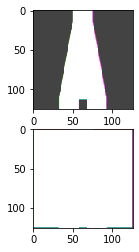

permittivity images


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def permittivity_to_image(permittivities):
    fig, ax = plt.subplots(len(permittivities))
    for i, perm in enumerate(permittivities):
        perm = np.abs(perm).astype('float')
        perm = np.squeeze(perm)
        perm = perm / np.max(perm)
        ax[i].imshow(perm, cmap='gray', interpolation='nearest', vmin=np.min(perm), vmax=np.max(perm))
    plt.show()

permittivity_to_image([eps_image, newly_set_eps_data])
print(f'permittivity images')
